In [4]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Lambda, Dropout, Flatten
from keras.layers.convolutional import Conv2D, Cropping2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

print(keras.__version__)


Using TensorFlow backend.


2.0.5


In [5]:
## Model Parameters
optimizer = 'adam'
loss = 'mse'
color_mode = "rgb" ##"rgb or gray_scale" ## or 
batch_size = 32
validation_split = 0.05
epochs = 3
dropout_keep_prob = 0.8
flipping_threshold = 0.0
translation_threshold = 10 #(set to high value to disable)
rotation_threshold = 0.15
rot_angle = 0.5
left_right_threshold = 0.0 #(set to zero to include all images)
max_samples_per_angle = 15000 # make it 7k
n_shifts_less_0_2 = 0
n_shifts_less_0_3 = 0 
n_shifts_less_0_4 = 0 # make it 20
n_shifts_more_0_4 = 0 # make it 25

model_save_as = "model_15k_3_steering_325.h5"
print ("Model will be saved as {}".format(model_save_as))           

Model will be saved as model_15k_3_steering_325.h5


In [6]:
## NVIDIA Architecture in Keras

def nvidia_for_driving(input_shape):
    
    model = Sequential()
   
    # Input 160x320x3 Output 36x200x3
    model.add(Lambda(lambda x:  (x / 255.0) - 0.5, input_shape = (160, 320, 3)))
    model.add(Cropping2D(cropping = ((70, 25), (0, 0))))

    # Input 36x200x3 Output 16x98x24
    model.add(Conv2D(24, (5, 5), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Input 16x98x24 Output 6x47x36
    model.add(Conv2D(36, (5, 5), strides = (2,2), padding = 'valid', activation = 'relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(48, (5, 5), strides = (2,2), padding = 'valid', activation = 'relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding = 'valid', activation = 'relu'))
    model.add(Dropout(dropout_keep_prob))

    model.add(Conv2D(64, (3, 3), padding = 'valid', activation = 'relu'))
    model.add(Dropout(dropout_keep_prob))
    
    model.add(Flatten())
    model.add(Dropout(dropout_keep_prob))
    model.add(Dense(100))
    model.add(Dropout(dropout_keep_prob))
    model.add(Dense(50))
    model.add(Dense(1))
    model.summary()
    
    return model


In [7]:
model = nvidia_for_driving((160, 320,3))
print ("Using Nvidia model for training")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 316, 24)       1824      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 158, 24)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 35, 64)         27712     
__________

In [8]:
## Experiment Parameters (LOCAL)
#import os
#base_dir = '/Users/raman/work/car_nd/p3'
#input_dir = os.path.join(base_dir, 'data')
#input_image_dir = os.path.join(input_dir, 'IMG')
#driving_log = os.path.join(input_dir, 'driving_log.csv')

In [9]:
## Experiment Parameters (AWS)
import os
base_dir = '/home/carnd/exp_5'
input_dir = os.path.join(base_dir, 'data_2')
input_image_dir = os.path.join(input_dir, 'IMG')
driving_log = os.path.join(input_dir, 'driving_log.csv')


In [10]:
class Utils:
    
    @staticmethod
    def turning_angle(angle, threshold):
        if angle <= -threshold or angle >= threshold:
            return True
        else:
            return False
                
    @staticmethod
    def flip_image(image):
        return np.fliplr(image)
    
    @staticmethod
    def shift_image(image):
        delta = randint(3, 10)
        if randint(0,1) == 0:
             sign = 1 
        else: 
            sign = -1 
        delta = sign * delta
        sequence = (0.0, delta, 0.0) 
        return ndimage.shift(image, sequence, mode="nearest")
    
    @staticmethod
    def add_left_right_images(image_dir, sample, angle):
        images = []
        angles = []
    
        # add left image
        image_path = sample[1].split('/')[-1]
        left_angle = angle + 0.325
        image_path = os.path.join(image_dir, image_path)
        images.append(Utils.read_image(image_path))
        angles.append(left_angle)

        # add right image
        image_path = sample[2].split('/')[-1]
        right_angle = angle - 0.325
        image_path = os.path.join(image_dir, image_path)
        images.append(Utils.read_image(image_path))
        angles.append(right_angle)
        return images, angles      
     
    @staticmethod
    def rotate_image(image, angle):
        x,y,c = image.shape
        image_center = tuple(np.array(image.shape)/2)
        rot_mat = cv2.getRotationMatrix2D((y/2, x/2),angle,1.0)
        rotated = cv2.warpAffine(image, rot_mat, 
                                (y,x),flags=cv2.INTER_NEAREST,
                                borderMode=cv2.BORDER_REPLICATE)
        
        return rotated
        
    @staticmethod
    def get_nshifts_from_angle(angle):
        rounded = round(angle, 1)
        if abs(rounded) <= 0.2:
            return n_shifts_less_0_2
        elif abs(rounded) <= 0.3:
            return n_shifts_less_0_3
        elif abs(rounded) <= 0.4:
            return n_shifts_less_0_4
        else:
            return n_shifts_more_0_4
        
    @staticmethod
    def read_image(image_path):
        return cv2.imread(image_path)
    
    @staticmethod
    def display_image(image, angle):
        plt.figure(figsize = (3,3))
        plt.title(str(angle))
        plt.imshow(image)

In [11]:
import cv2
import csv
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from random import randint
from scipy import ndimage

class CustomDataGen:
    def __init__(self, image_dir, driving_log):
        self.image_dir = image_dir
        self.driving_log = driving_log
    
    @staticmethod
    def build_samples(driving_log):
        samples = []
        with open(driving_log) as csvfile:
            reader = csv.reader(csvfile)
            first_line = True
            for line in reader:
                if first_line:
                    first_line = False
                    continue
                samples.append(line)
        return samples
    
    def pre_process(self, sample):
        images = []
        angles = []
        
        # add center image
        image_path = sample[0].split('/')[-1]
        image_path = os.path.join(self.image_dir, image_path)
        image = Utils.read_image(image_path)
        images.append(image)
        angle = float(sample[3])
        angles.append(angle)
            
        # conditionally add flipped images (if angle > threshold)
        if Utils.turning_angle(angle, flipping_threshold) is True:
            images.append(Utils.flip_image(image))
            angles.append(-1 * angle)
        
        # add left right image with adjusted steering
        if Utils.turning_angle(angle, left_right_threshold) is True:
            s_images, s_angles = Utils.add_left_right_images(self.image_dir, sample, angle)
            images.extend(s_images)
            angles.extend(s_angles)
        
        # add translated images 
        if Utils.turning_angle(angle, translation_threshold) is True:
            n_shifts = Utils.get_nshifts_from_angle(angle)
            for index in range(n_shifts):
                s_image = Utils.shift_image(image)
                images.append(s_image)
                angles.append(angle)
                
        # add rotation images        
        if Utils.turning_angle(angle, rotation_threshold) is True:
            right_rotated = Utils.rotate_image(image, rot_angle)
            left_rotated  = Utils.rotate_image(image, -rot_angle)
            images.append(right_rotated)
            images.append(left_rotated)
            angles.append(angle)
            angles.append(angle)
              
        return images, angles
    
    def generate(self, samples, batch_size = 32):
        num_samples = len(samples)
        batch_counter = 0
        while True:
            shuffle(samples)
            for offset in range(0, num_samples, batch_size):
                begin = offset
                end = begin + batch_size
                batch_samples = samples[begin: end]

                batch_images = []
                batch_angles = []
                for sample in batch_samples:
                    images, angles = self.pre_process(sample)
                    batch_images.extend(images)
                    batch_angles.extend(angles)
                    
                X_train = np.asarray(batch_images)
                y_train = np.asarray(batch_angles)
                yield sklearn.utils.shuffle(X_train, y_train)


In [12]:
datagen = CustomDataGen(input_image_dir, driving_log)
samples = CustomDataGen.build_samples(driving_log)
print("Number of samples {}".format(len(samples)))

Number of samples 15302


In [13]:
from sklearn.model_selection import train_test_split

model.compile(loss = loss, optimizer = optimizer)

samples = CustomDataGen.build_samples(driving_log)
train_samples, validation_samples = train_test_split(samples, test_size = 0.05)
print ("Samples: Training {}, Validation {}".format(len(train_samples), len(validation_samples)))

datagen = CustomDataGen(input_image_dir, driving_log)
samples = CustomDataGen.build_samples(driving_log)

train_generator = datagen.generate(train_samples)
num_batches_train = np.ceil(len(train_samples)/batch_size)
print ("# of training batches {}".format(num_batches_train))

datagen = CustomDataGen(input_image_dir, driving_log)
validation_generator = datagen.generate(validation_samples)
num_batches_validation = np.ceil(len(validation_samples)/batch_size)
print ("# of validation batches {}".format(num_batches_validation))

Samples: Training 14536, Validation 766
# of training batches 455.0
# of validation batches 24.0


total measurements before augmentation1000
4356


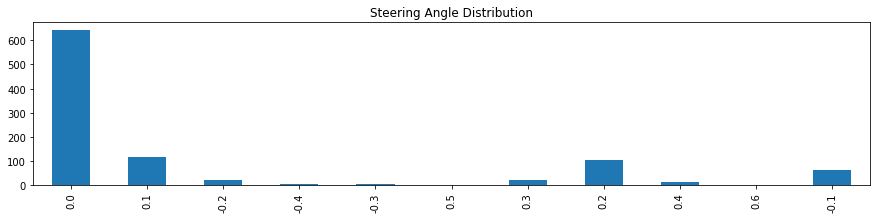

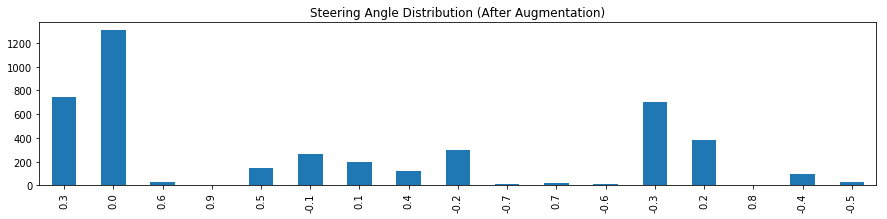

In [14]:
import pandas
from collections import Counter
import matplotlib.pyplot as plt


def histogram(collection, name, title):
    sign_type_counts = Counter(collection)
    df = pandas.DataFrame.from_dict(sign_type_counts, orient='index')
    df.reindex_axis(sorted(df.columns), axis=0)
    df.plot(kind='bar', legend = False, figsize = (15, 3), title =  title)
    
## histogram of types of images in the training dataset
angles = []
shuffle(samples)
for sample in samples[0:1000]:
    angle = round(float(sample[3]), 1)
    angles.append(angle)
print("total measurements before augmentation{}".format(len(angles)))
histogram(angles, "Steering Angle", "Steering Angle Distribution")


X,y = next(datagen.generate(samples, 1000))
print(len(X))
angles = []
for orig in y:
    rounded = round(float(orig), 1)
    angles.append(rounded)

for img in X:
    pass
    #Utils.display_image(img, None)

histogram(angles, "Steering Angle", "Steering Angle Distribution (After Augmentation)")

plt.show()
plt.close()


In [16]:
history_object = model.fit_generator(
    train_generator,
    steps_per_epoch = num_batches_train,
    epochs=3, 
    verbose=1,
    validation_data = validation_generator,
    validation_steps = num_batches_validation
    )

model.save(model_save_as)
print("model saved as {}".format(model_save_as))

Epoch 1/3
455/455 [==============================] - 175s - loss: 0.0610 - val_loss: 0.0494
Epoch 2/3
455/455 [==============================] - 168s - loss: 0.0455 - val_loss: 0.0405
Epoch 3/3
455/455 [==============================] - 168s - loss: 0.0411 - val_loss: 0.0329
model saved as model_15k_3_steering_325.h5


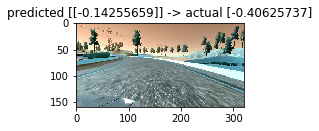

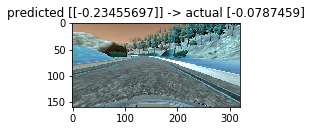

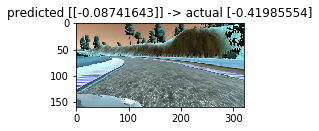

In [21]:
import matplotlib.pyplot as plt

datagen = CustomDataGen(input_image_dir, driving_log)
validation_generator = datagen.generate(validation_samples, batch_size = 5)

for i in range(1):
    X_batch, y_batch = next(validation_generator)  
    angles = model.predict(X_batch)
    for index in range(3):
        msg = "predicted [{}] -> actual [{}]".format(angles[index], y_batch[index])
        Utils.display_image(X_batch[index].squeeze(), msg)

plt.show()
plt.close()

dict_keys(['val_loss', 'loss'])


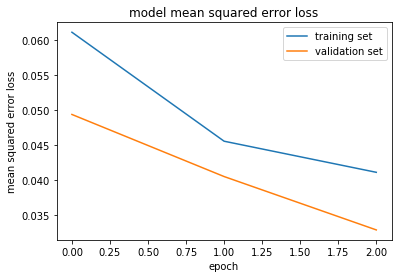

In [17]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()